In [1]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [2]:
outdict = readinput("chem40.rms")


[20:36:18] WARNING: not removing hydrogen atom without neighbors
[20:36:18] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];
sitedensity = 2.292e-5; # Ag111

In [4]:
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [5]:
initialcondsliq = Dict(["proton"=>10.0^-4,"CO2"=>10.0^-3*10^3,
        "V"=>1.0,"T"=>298.15,"Phi"=>0.0,"d"=>0.0]);
AVratio = 1.0e5
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
        "CHO2X"=>0.1*sitedensity*AVratio,
        "CO2HX"=>0.1*sitedensity*AVratio,
        "OX"=>0.1*sitedensity*AVratio,
        "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>0.1*sitedensity*AVratio,
        "CH2O2X"=>0.05*sitedensity*AVratio,
        "CHOX"=>0.04*sitedensity*AVratio,
        "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>298.15,"Phi"=>-1.5]);

In [6]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [7]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [8]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e2), [inter], (pliq,pcat,pinter));


 17.871423 seconds (50.99 M allocations: 3.042 GiB, 9.76% gc time, 99.92% compilation time: <1% of which was recompilation)


In [9]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-6);

  6.703691 seconds (18.98 M allocations: 1.132 GiB, 8.49% gc time, 98.73% compilation time)


In [10]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 2908-element Vector{Float64}:
   0.0
   3.031374015121894e-26
   6.062748030243788e-26
   3.085076213075436e-25
   2.787309031358601e-24
   5.266110441409658e-24
   1.0457491810117826e-23
   2.20986179432252e-23
   4.968816628317385e-23
   1.1773938240787836e-22
   ⋮
  92.51088954437755
  93.16173883241676
  93.81258812045597
  94.46343740849518
  95.45628473700712
  96.44913206551907
  97.9735065362638
  99.49788100700853
 100.0
u: 2908-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0001, 1.8698309326307656e-64, 2.6749842732907065e-25, 1.004534228116091e-25, 3.942297170750963e-31  …  1.6310793713193405e-20, 4.625398656854179e-22, 1.151581268844788e-31, 1.7308580762475715e-23, 7.591042915153501e-28, 1.7054949285828812e-17, 5.660254572472688e-33, 5.219914965126757e-27, 2.6434382701722622e-18, 5.2519606835423e-37]


In [11]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [12]:
ssys.reactions

205-element Vector{ElementaryReaction}:
 OX+OCX<=>vacantX+CO2X
 vacantX+CHO2X<=>OX+CHOX
 CHO2X+CHO2X<=>CO2X+CH2O2X
 CHO2X+CO2HX<=>CO2X+CH2O2X
 CHO2X+CO2HX<=>CO2X+CH2O2X
 CO2HX+CO2HX<=>CO2X+CH2O2X
 OCX+CHO2X<=>CO2X+CHOX
 OCX+CO2HX<=>CO2X+CHOX
 CHOX+CHO2X<=>CO2X+CH2OX
 CHOX+CO2HX<=>CO2X+CH2OX
 ⋮
 proton+OC[Pt]<=>CO.[Pt]
 vacantX+O=[C]O<=>CO2HX
 vacantX+vacantX+CO-2<=>HX+CO[Pt]
 vacantX+vacantX+CO-2<=>HX+OC[Pt]
 proton+OCO[Pt]<=>OX+CO-2
 vacantX+CO-2<=>CO.[Pt]
 proton+OCX<=>OC#[Pt]
 proton+OC#[Pt]<=>OC=[Pt]
 vacantX+vacantX+C=O<=>[Pt]CO[Pt]

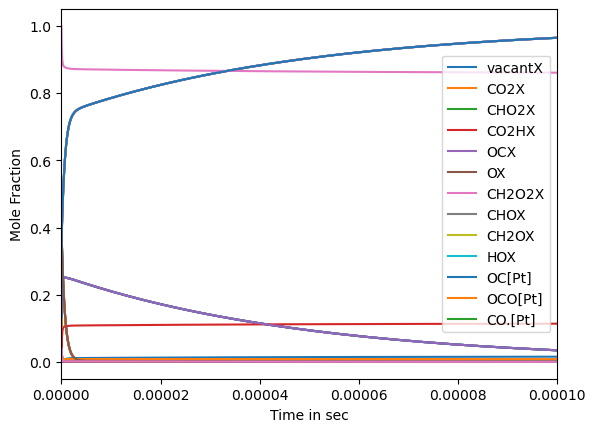

In [28]:
#Plot surface fractions
plotmolefractions(ssys.sims[2];tol=1e-3)
xlim(0.0,1e-4)
gcf()

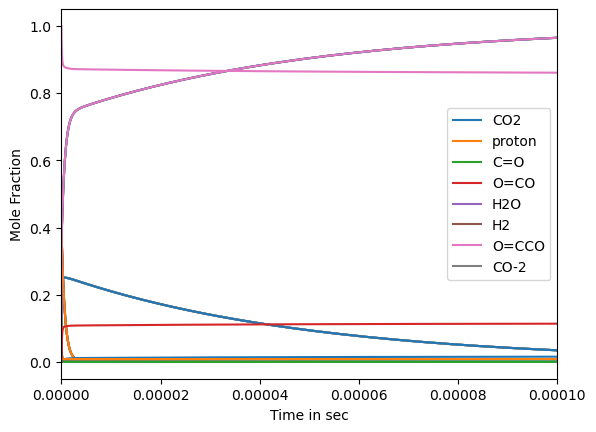

In [27]:
#Plot surface fractions
plotmolefractions(ssys.sims[1];tol=1e-9)
xlim(0.0,1e-4)
gcf()

In [19]:
Dict([ssys.sims[2].names[i]=>molefractions(ssys.sims[2],1.0)[i] for i in 1:length(ssys.sims[2].names)])

Dict{String, Float64} with 22 entries:
  "CO2HX"         => 9.2894e-12
  "CHOX"          => 6.12125e-13
  "CH2O2X"        => 0.999972
  "CO2X"          => 3.91658e-7
  "O=COC[Pt]"     => 9.46787e-26
  "[Pt]CO[Pt]"    => 6.13294e-37
  "OC(O)[Pt]"     => 3.65538e-13
  "HX"            => 4.06371e-15
  "OX"            => 3.07236e-26
  "OCO[Pt]"       => 3.84895e-14
  "CO[Pt]"        => 5.62221e-22
  "OC[Pt]"        => 1.01797e-14
  "OC([Pt])O[Pt]" => 4.75811e-13
  "CH2OX"         => 2.31164e-11
  "CHO2X"         => 7.42187e-20
  "HOX"           => 4.39617e-10
  "OC#[Pt]"       => 2.35236e-25
  "OC=[Pt]"       => 4.55929e-19
  "CO.[Pt]"       => 2.18295e-7
  ⋮               => ⋮

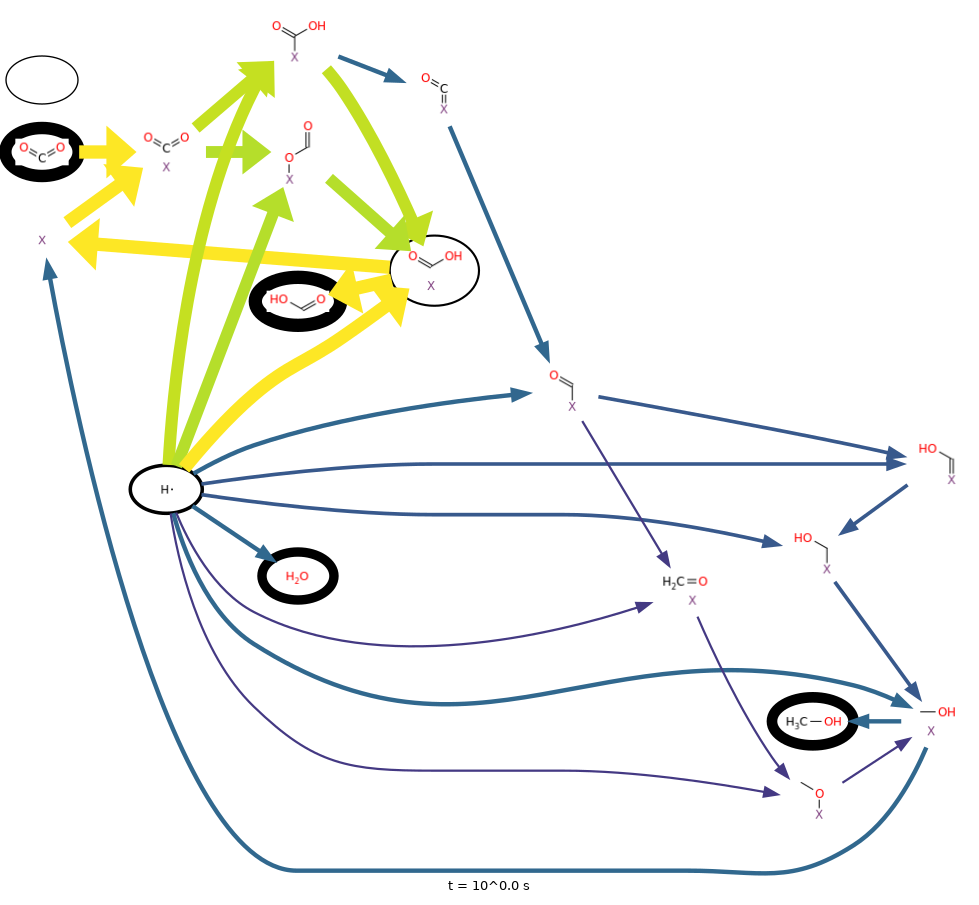

In [26]:
getfluxdiagram(ssys,1;speciesratetolerance=1e-3)

In [29]:
println(ssys.names)

["Ar", "He", "Ne", "N2", "CO2", "proton", "H", "C=O", "O=CO", "O=CC=O", "H2O", "H2", "COC=O", "[CH]=O", "O=CCO", "[O]C=O", "O=[C]O", "CO-2", "vacantX", "CO2X", "CHO2X", "CO2HX", "OCX", "OX", "CH2O2X", "CHOX", "CH2OX", "HOX", "CO[Pt]", "OC[Pt]", "HX", "OC([Pt])O[Pt]", "OC(O)[Pt]", "OCO[Pt]", "O=COC[Pt]", "OC=[Pt]", "O=CC(=O)[Pt]", "CO.[Pt]", "OC#[Pt]", "[Pt]CO[Pt]"]


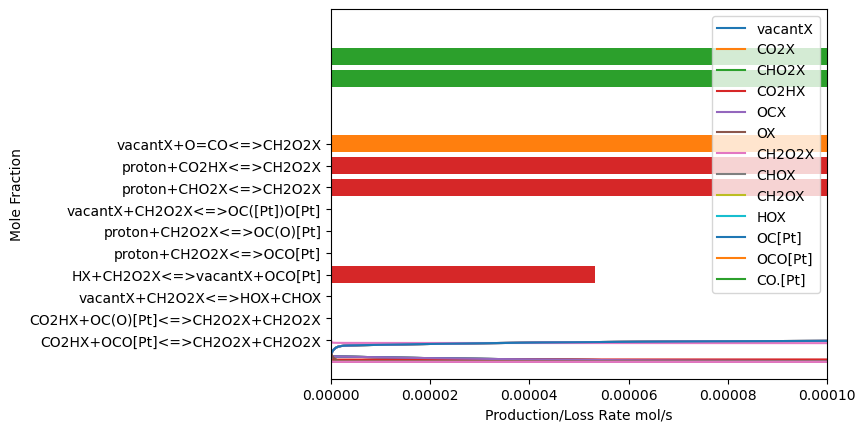

In [33]:
plotrops(ssys,"CH2O2X",1;N=10,tol=0.0)
gcf()

In [31]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [ ]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [ ]:
plotrops(ssys,"OX",1;N=10,tol=0.0)
gcf()

In [ ]:
plotrops(ssys,"OCX",1.0e-6)
gcf()

In [35]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 10788.165454337284
Kc = 1.9145623981394808
proton+CO2X<=>CHO2X
kf = 398101.97645878926
krev = 7.156914503801756e14
Kc = 5.562480538887496e-10
proton+CO2X<=>CO2HX
kf = 27.54791541056244
krev = 0.20100970088358547
Kc = 137.04769117843114
proton+CHO2X<=>CH2O2X
kf = 1.2481838920612775e14
krev = 1.358756501081174e-13
Kc = 9.18622204249317e26
proton+CO2HX<=>CH2O2X
kf = 1.1401909465177334e6
krev = 3.0580449760320587e-10
Kc = 3.7284963283868335e15
proton+OCX<=>CHOX
kf = 3.683552125531099e8
krev = 0.0011098554096784935
Kc = 3.318947759688951e11
proton+CHOX<=>CH2OX
kf = 106293.14399270627
krev = 8.611726433031258e-7
Kc = 1.2342837968587439e11
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093940742e-24
krev = 2.846519032292493e15
Kc = 1.0577648613047058e-39
OX+proton<=>HOX
kf = 3.721571205265217e13
krev = 0.020996089992731126
Kc = 1.772506788908616e15
vacantX+C=O<=>CH2OX
kf = 500114.1348800291
krev = 385.00564402129214
Kc = 1298.9787101728073
proton+